In [2]:
import nibabel as nib, numpy as np, seaborn as sns, matplotlib, matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth
import scipy
import sklearn
from sklearn import metrics
from scipy.stats import ttest_ind
import subprocess, os
from sklearn.cluster import KMeans
from nibabel.affines import apply_affine
import numpy.linalg as npl, nilearn
from nilearn import plotting

In [292]:
# first transform cerebral cortical gradients dscalar to volume with this:
subprocess.check_output("wb_command -cifti-separate result_bilateralcortex.dscalar.nii COLUMN -metric CORTEX_LEFT CerebralCortexGradients_cortexleft.gii", shell=True);
subprocess.check_output("wb_command -metric-to-volume-mapping CerebralCortexGradients_cortexleft.gii S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii mT1wdivT2w_100average.nii CerebralCortexGradients_volume_cortexleft.nii -nearest-vertex 4", shell=True);
subprocess.check_output("wb_command -cifti-separate result_bilateralcortex.dscalar.nii COLUMN -metric CORTEX_RIGHT CerebralCortexGradients_cortexright.gii", shell=True);
subprocess.check_output("wb_command -metric-to-volume-mapping CerebralCortexGradients_cortexright.gii S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii mT1wdivT2w_100average.nii CerebralCortexGradients_volume_cortexright.nii -nearest-vertex 4", shell=True);
subprocess.check_output("fslmaths CerebralCortexGradients_volume_cortexright.nii -add CerebralCortexGradients_volume_cortexleft.nii CerebralCortexGradients_volume_cortexrightandleft.nii", shell=True);


In [293]:
# then segment the T1w average S1200 file from HCP with SPM segment, and use the GM 
# mask (c1) to mask the gradient volumetric file:

subprocess.check_output("fslmaths c1mT1wdivT2w_100average.nii -thr 0.99 -bin c1mT1wdivT2w_100average_thr0point99_bin.nii.gz", shell=True);
subprocess.check_output("fslmaths mT1wdivT2w_100average.nii -mul c1mT1wdivT2w_100average_thr0point99_bin.nii.gz mT1wdivT2w_100average_GMmask.nii.gz", shell=True);
subprocess.check_output("fslmaths CerebralCortexGradients_volume_cortexrightandleft.nii.gz -mul c1mT1wdivT2w_100average_thr0point99_bin.nii.gz CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz", shell=True);


In [322]:
gradients = nib.load('CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz').get_data()
T1wT2w = nib.load('mT1wdivT2w_100average_GMmask.nii.gz').get_data()

In [296]:
gradients.shape

(260, 311, 260, 8)

In [297]:
T1wT2w.shape

(260, 311, 260)

In [323]:
gradient1 = gradients[:,:,:,0]
gradient2 = gradients[:,:,:,1]
gradient3 = gradients[:,:,:,2]
gradient1.shape

(260, 311, 260)

In [324]:
gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())
T1wT2w.shape == gradient1.shape


True

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
-----------------------------------------------------------------
iter  parent  var  knot    mse       terms  gcv    rsq    grsq   
-----------------------------------------------------------------
0     -       -    -       0.045691  1      0.046  0.000  0.000  
1     0       0    431905  0.044855  3      0.045  0.018  0.018  
-----------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.04  0.045  0.018  0.018  
1     1   2      0.04  0.045  0.018  0.018  
2     2   1      0.05  0.046  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.82766      
h(x0-19.4948)   No   

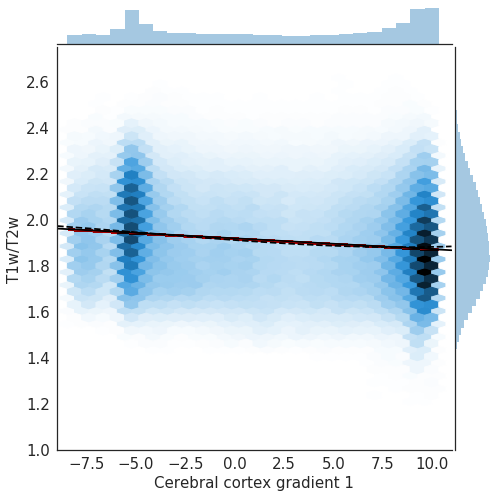

In [333]:
# cerebral cortex volumetric, gradient 1 structure-function correlations

gradient = gradient1.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-9, 11], ylim=[1, 2.75],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 1', 'T1w/T2w', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
-----------------------------------------------------------------
iter  parent  var  knot    mse       terms  gcv    rsq    grsq   
-----------------------------------------------------------------
0     -       -    -       0.045691  1      0.046  0.000  0.000  
1     0       0    -1      0.045592  2      0.046  0.002  0.002  
2     0       0    343742  0.045592  4      0.046  0.002  0.002  
-----------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   4      0.05  0.046  0.002  0.002  
1     2   3      0.05  0.046  0.002  0.002  
2     3   2      0.05  0.046  0.002  0.002  
3     1   1      0.05  0.046  0.000  0.000  
--------------------------------------------
Selected iteration: 2

Earth Model
-------------------------------------
Basis Function  Pruned  

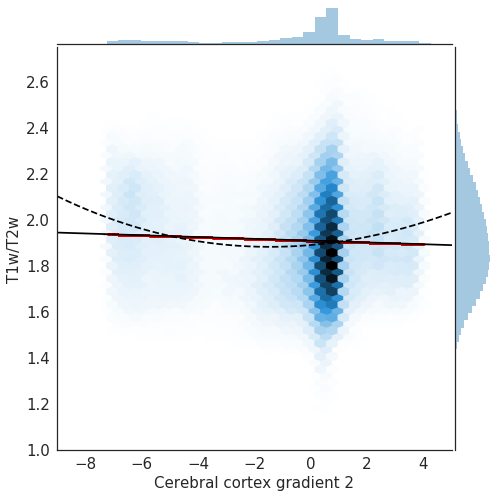

In [332]:
# cerebral cortex volumetric, gradient 2 structure-function correlations


gradient = gradient2.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-9, 5], ylim=[1, 2.75],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 2', 'T1w/T2w', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
-----------------------------------------------------------------
iter  parent  var  knot    mse       terms  gcv    rsq    grsq   
-----------------------------------------------------------------
0     -       -    -       0.045691  1      0.046  0.000  0.000  
1     0       0    431906  0.045689  3      0.046  0.000  0.000  
-----------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.05  0.046  0.000  0.000  
1     2   2      0.05  0.046  0.000  0.000  
2     1   1      0.05  0.046  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
--------------------------------------
Basis Function  Pruned  Coefficient   
--------------------------------------
(Intercept)     No      1.91256       
h(x0-5.54831)   N

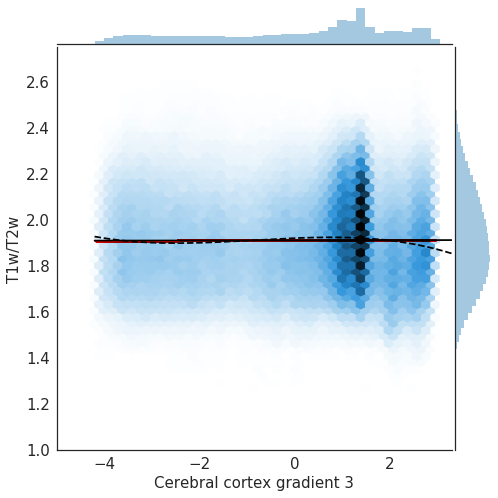

In [331]:
# cerebral cortex volumetric, gradient 3 structure-function correlations


gradient = gradient3.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-5, 3.3], ylim=[1, 2.75],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 3', 'T1w/T2w', fontsize=15))

x= gradient
xp = np.linspace(np.min(x), np.max(x), len(x)) 
y= myelin
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = gradient
yearth = myelin
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(myelin, gradient)
spear_r = scipy.stats.spearmanr(myelin, gradient)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

In [3]:
# calculate the same but with myelin parcels, this dimentionality reduction might increase our
# power to observe relationships

gradients = nib.load('CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz').get_data()
T1wT2w = nib.load('mT1wdivT2w_100average_GMmask.nii.gz').get_data()
gradient1 = gradients[:,:,:,0]
gradient2 = gradients[:,:,:,1]
gradient3 = gradients[:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient1.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]



In [4]:
# K-MEANS CLUSTERING BASED ON GRADIENT 1 VALUES

gradient.shape=(859034, 1)
cls = KMeans(n_clusters=1000)
cls.fit(gradient)
labels = cls.labels_
gradient.shape=(859034,)
# get median of gradient1 values and median of T1wT2w values at each parcel

In [5]:
np.save('__labels_1000kmeansGradient1.npy',labels)

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.003546  1      0.004  0.000  0.000  
1     0       0    869   0.001884  3      0.002  0.469  0.463  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.00  0.002  0.469  0.463  
1     2   2      0.00  0.002  0.309  0.305  
2     1   1      0.00  0.004  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.82858      
h(x0-18.1688)   No      -0.329348

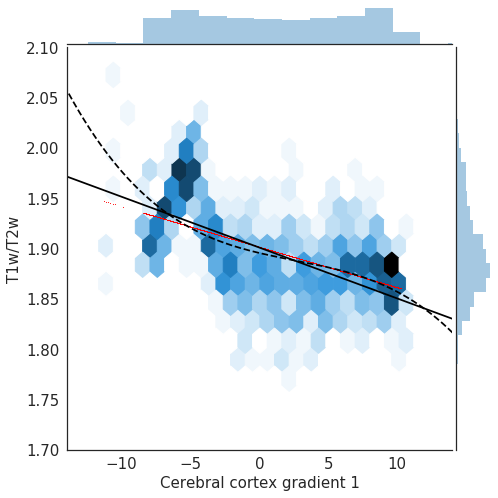

In [18]:
# cerebral cortex volumetric, gradient 1 structure-function correlations
# after k-means clustering based on gradient 1 values

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

gradients = nib.load('CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz').get_data()
T1wT2w = nib.load('mT1wdivT2w_100average_GMmask.nii.gz').get_data()
gradient1 = gradients[:,:,:,0]
gradient2 = gradients[:,:,:,1]
gradient3 = gradients[:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient1.copy()
myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

labels = np.load('__labels_1000kmeansGradient1.npy')

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

gradient = np.array(list(y1))
myelin = np.array(list(y2))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-14, 14], ylim=[1.7, 2.1],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 1', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)


# substitute gradient and myelin for x and y
Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clustersKmeansOfGradient1_cerebrum_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.003546  1      0.004  0.000  0.000  
1     0       0    864   0.002621  3      0.003  0.261  0.253  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.00  0.003  0.261  0.253  
1     1   2      0.00  0.003  0.172  0.167  
2     2   1      0.00  0.004  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.86382      
h(x0-1.24929)   No      0.0290443

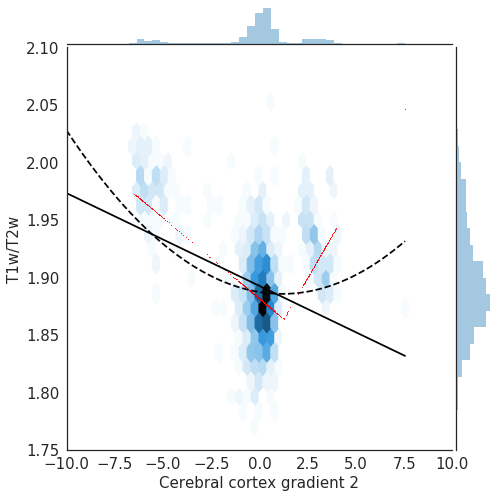

In [16]:
# cerebral cortex volumetric, gradient 2 structure-function correlations
# after k-means clustering based on gradient 1 values

gradients = nib.load('CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz').get_data()
T1wT2w = nib.load('mT1wdivT2w_100average_GMmask.nii.gz').get_data()
gradient1 = gradients[:,:,:,0]
gradient2 = gradients[:,:,:,1]
gradient3 = gradients[:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient2.copy()
myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

labels = np.load('__labels_1000kmeansGradient1.npy')


dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

gradient = np.array(list(y1))
myelin = np.array(list(y2))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-10, 10], ylim=[1.75, 2.1],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 2', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 2) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)


# substitute gradient and myelin for x and y
Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clustersKmeansOfGradient1_cerebrum_gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.003546  1      0.004  0.000  0.000  
1     0       0    826   0.002026  3      0.002  0.428  0.423  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.00  0.002  0.428  0.423  
1     2   2      0.00  0.003  0.265  0.261  
2     1   1      0.00  0.004  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.93862      
h(x0-1.4144)    No      -0.095499

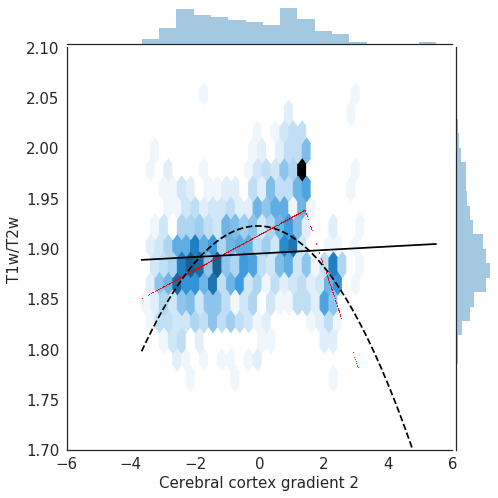

In [17]:
# cerebral cortex volumetric, gradient 3 structure-function correlations
# after k-means clustering based on gradient 1 values

gradients = nib.load('CerebralCortexGradients_volume_cortexrightandleft_GMmasked.nii.gz').get_data()
T1wT2w = nib.load('mT1wdivT2w_100average_GMmask.nii.gz').get_data()
gradient1 = gradients[:,:,:,0]
gradient2 = gradients[:,:,:,1]
gradient3 = gradients[:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient3.copy()
myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

labels = np.load('__labels_1000kmeansGradient1.npy')


dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

gradient = np.array(list(y1))
myelin = np.array(list(y2))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-6, 6], ylim=[1.7, 2.1],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebral cortex gradient 2', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 2) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)


# substitute gradient and myelin for x and y
Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clustersKmeansOfGradient1_cerebrum_gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


Text(0.5,0,'myelin averaged across myelin parcels')

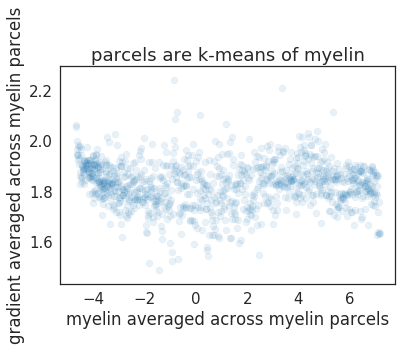

In [25]:
# same approach of k-means clustering based on gradient 1 values, in the cerebellum

# cerebellar cortex volumetric, gradient 1 structure-function correlations
# after k-means clustering based on gradient 1 values

gradients = nib.load('result_fromcerebellumtocerebellum.dscalar.nii').get_data()
T1wT2w = nib.load('myelin_cerebellumonly_100average.dscalar.nii').get_data()
gradient1 = gradients[:,:,:,:,0]
gradient2 = gradients[:,:,:,:,1]
gradient3 = gradients[:,:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient1.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

gradient.shape=(17853, 1)
cls = KMeans(n_clusters=1000)
cls.fit(gradient)
labels = cls.labels_
gradient.shape=(17853,)
# get median of gradient1 values and median of T1wT2w values at each parcel

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

plt.scatter(y2, y1, alpha=0.1)
plt.title('parcels are k-means of myelin')
plt.ylabel('gradient averaged across myelin parcels')
plt.xlabel('myelin averaged across myelin parcels')

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.008081  1      0.008  0.000  0.000  
1     0       0    90    0.007431  3      0.008  0.080  0.071  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.01  0.008  0.080  0.071  
1     1   2      0.01  0.008  0.062  0.057  
2     2   1      0.01  0.008  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.79759      
h(x0+2.85123)   No      0.0042972

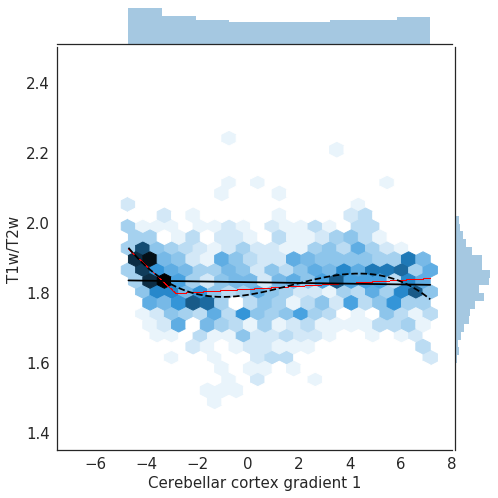

In [29]:
gradient = np.array(list(y2))
myelin = np.array(list(y1))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-7.5, 8], ylim=[1.35, 2.5],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebellar cortex gradient 1', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clusters_cerebellum_gradient1.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


Text(0.5,0,'myelin averaged across myelin parcels')

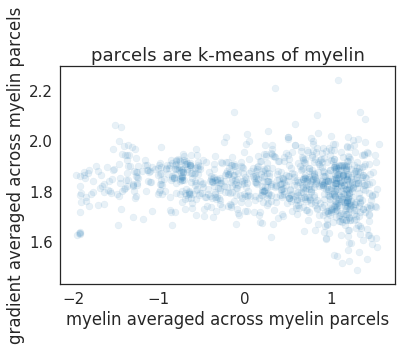

In [30]:
# cerebellar cortex volumetric, gradient 2 structure-function correlations
# after k-means clustering based on gradient 1 values

gradients = nib.load('result_fromcerebellumtocerebellum.dscalar.nii').get_data()
T1wT2w = nib.load('myelin_cerebellumonly_100average.dscalar.nii').get_data()
gradient1 = gradients[:,:,:,:,0]
gradient2 = gradients[:,:,:,:,1]
gradient3 = gradients[:,:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient2.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

gradient.shape=(17853, 1)
#cls = KMeans(n_clusters=1000)
#cls.fit(gradient)
#labels = cls.labels_
gradient.shape=(17853,)
# get median of gradient1 values and median of T1wT2w values at each parcel

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

plt.scatter(y2, y1, alpha=0.1)
plt.title('parcels are k-means of myelin')
plt.ylabel('gradient averaged across myelin parcels')
plt.xlabel('myelin averaged across myelin parcels')

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.008081  1      0.008  0.000  0.000  
1     0       0    446   0.007646  3      0.008  0.054  0.044  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.01  0.008  0.054  0.044  
1     2   2      0.01  0.008  0.026  0.022  
2     1   1      0.01  0.008  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      1.87293      
h(x0+1.53598)   No      -0.022961

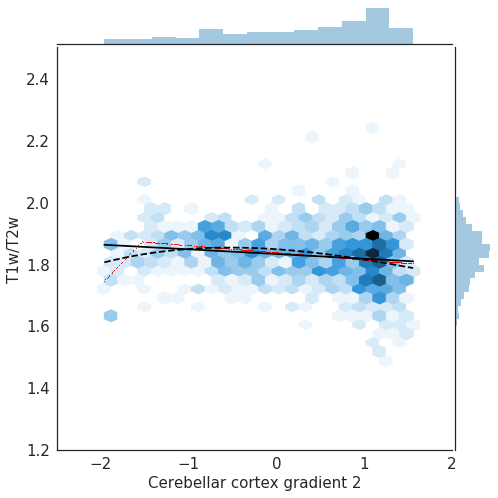

In [32]:
gradient = np.array(list(y2))
myelin = np.array(list(y1))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-2.5, 2], ylim=[1.2, 2.5],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebellar cortex gradient 2', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)

Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clusters_cerebellum_gradient2.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()

/home/xavierguell/.local/lib/python3.5/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


Text(0.5,0,'myelin averaged across myelin parcels')

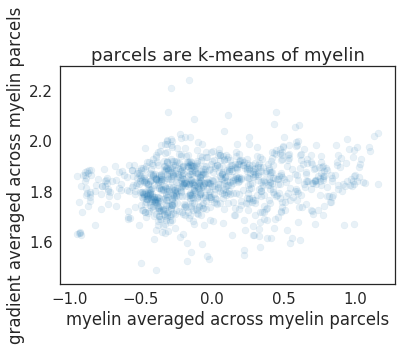

In [33]:
# cerebellar cortex volumetric, gradient 3 structure-function correlations
# after k-means clustering based on gradient 1 values

gradients = nib.load('result_fromcerebellumtocerebellum.dscalar.nii').get_data()
T1wT2w = nib.load('myelin_cerebellumonly_100average.dscalar.nii').get_data()
gradient1 = gradients[:,:,:,:,0]
gradient2 = gradients[:,:,:,:,1]
gradient3 = gradients[:,:,:,:,2]

gradient1 = np.ndarray.flatten(gradient1.copy())
gradient2 = np.ndarray.flatten(gradient2.copy())
gradient3 = np.ndarray.flatten(gradient3.copy())
T1wT2w = np.ndarray.flatten(T1wT2w.copy())

gradient = gradient3.copy()

myelin = T1wT2w.copy()[gradient!=0] # exclude parts of the myelin map where there are no gradient 1 values
gradient = gradient.copy()[gradient!=0]

gradient.shape=(17853, 1)
#cls = KMeans(n_clusters=1000)
#cls.fit(gradient)
#labels = cls.labels_
gradient.shape=(17853,)
# get median of gradient1 values and median of T1wT2w values at each parcel

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=myelin[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x1=np.arange(0, len(np.unique(labels)))
y1=dict_values_median.values()

dict_values = {}
for x in np.unique(labels):
    dict_values[x]=gradient[labels==x]
    
dict_values_median = {}
for x in dict_values:
    dict_values_median[x] = np.median(dict_values[x])

x2=np.arange(0, len(np.unique(labels)))
y2=dict_values_median.values()

plt.scatter(y2, y1, alpha=0.1)
plt.title('parcels are k-means of myelin')
plt.ylabel('gradient averaged across myelin parcels')
plt.xlabel('myelin averaged across myelin parcels')

/home/xavierguell/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/xavierguell/.local/lib/python3.5/site-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.008081  1      0.008  0.000  0.000  
1     0       0    488   0.007771  3      0.008  0.038  0.029  
---------------------------------------------------------------
Stopping Condition 0: Reached maximum number of terms

Pruning Pass
--------------------------------------------
iter  bf  terms  mse   gcv    rsq    grsq   
--------------------------------------------
0     -   3      0.01  0.008  0.038  0.029  
1     2   2      0.01  0.008  0.031  0.026  
2     1   1      0.01  0.008  0.000  0.000  
--------------------------------------------
Selected iteration: 0

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      1.80062      
h(x0+0.885252)   No      0.03

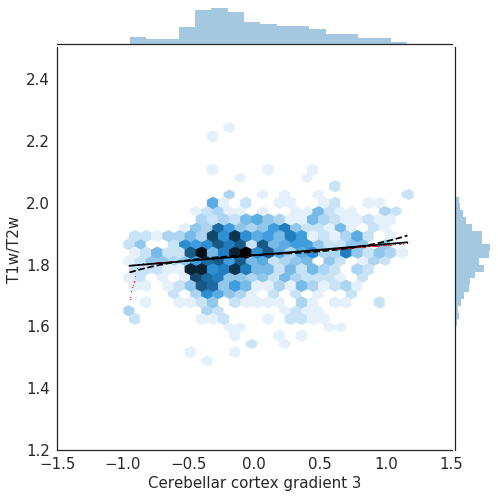

In [34]:
gradient = np.array(list(y2))
myelin = np.array(list(y1))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

fig = (sns.jointplot(gradient, myelin, kind='hex', size=7, ratio=10,
                     xlim = [-1.5, 1.5], ylim=[1.2, 2.5],
                     space=0.1,
                     stat_func=None).set_axis_labels('Cerebellar cortex gradient 3', 'T1w/T2w', fontsize=15))


x= gradient
y= myelin

# exclude nans to avoid "ValueError: On entry to DLASCL parameter number 4 had an illegal value"
ii = np.isfinite(x)
x = x[ii]
iii = np.isfinite(y)
y = y[iii]
##

xp = np.linspace(np.min(x), np.max(x), len(x)) 
z3 = np.polyfit(x, y, 3) 
p3 = np.poly1d(z3) 
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)


# substitute gradient and myelin for x and y
Xearth = x.copy()
yearth = y.copy()
model = Earth(max_degree= None, max_terms=2)
model.fit(Xearth,yearth)
print(model.trace())
print(model.summary())
yearth_hat = model.predict(Xearth)

fig.ax_joint.plot(Xearth, yearth_hat, 'r.', xp, p3(xp), 'k--', xp, p1(xp), 'k-', markersize=2.1)
fig.savefig(os.path.abspath('./_1000clusters_cerebellum_gradient3.png'), format='png', dpi=600, transparent=False)

pear_r = scipy.stats.pearsonr(y, x)
spear_r = scipy.stats.spearmanr(y, x)
print('Linear equation: ', (np.poly1d(p1)))
print('Pearson r linear equation: ', pear_r[0], ', r^2: ', (pear_r[0]*pear_r[0]))
print('Pearson p linear equation: ', pear_r[1])
print('Spearman r linear equation: ', spear_r[0])
print('Spearman p linear equation: ', spear_r[1])
print('Cubic equation:')
print(np.poly1d(p3))
print('r^2 for cubic equation: ', sklearn.metrics.r2_score(y, p3(x)))
print( 'r^2 for spline: ', (model.score(Xearth, yearth)))

plt.show()